In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    
    '''f_E = []
    for e in energies:
        print(e)
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
# Copyright 2011-2018 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

import numpy as np
from scipy.optimize import newton, brentq, minimize_scalar
from _boundstate_hermitian import eig_values, false_positive_BS, eig_val_derivative
from _boundstate_svd import singular_values
from _boundstate_common import *

__all__ = ['bound_state', 'wf_in_leads']

def bound_state(syst, E_range, args=(), params=None, tol=1e-8, sparse=False, 
                return_wf=False, maxiter=100, eig_val=2, need_orth=True):
    """Find a single bound state in the energy window '(emin, emax)'.

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have at least one lead attached. If you need to find bound
        states of a finite system, use an eigensolver.
    emin, emax : float
        The energy bounds in which to search for bound states.
    E_0: starting point of the newton method
    args : tuple
        Positional arguments to the system.
    params : dict
        Keyword arguments to the system.
    eps : float
        Tolerance with which to find the bound state.
    return_wavefunction : bool
        Whether or not to return the bound state wavefunction.
    maxiter: maximum number of steps used by the newton method
    eig_val: the number of eigenvalue to be computed. Only if sparse 
             is True
    need_orth: Whether to orthogonalize the leads modes. Only necessary 
               for degenerate eigenmodes

    Returns
    -------
    E: energy of the bound state
    if return _wf is True:
        psi_alpha_0: wavefunction in the scattering region
        lmb: Evanescent modes in the lead at a given energy
        q_e: 
        Phi: 
    elements fo compute the wavefunction in the leads

    Notes
    -----
    TODO: finish this docstring
    Can use Newton method to find the root. Downside of this method: 
    -needs a good initial guess (i.e. first Taylor expansion term bigger
     than others) 
    -assume that the minimal eigenvalue is a smooth function, which is 
     not the case when a mode opens in the lead, or when the minimal 
     eigenvalue changes
    Upside: Fast
    Brentq:
    from scipy, "Generally considered the best of the rootfinding routines here"

    Returns at most 1 bound state...
    """
    mat = extract_kwant_matrices(syst, sparse=sparse, args=args, params=params)

    # To use Singular value decomposition and look for a minimum
    return SVD_formulation(mat, E_range, tol, return_wf=return_wf, sparse=sparse)
    # To use eigenvalue decomposition and look for a root
    # return Hermitian_formulation(mat, E_0, return_wf=return_wf)

def SVD_formulation(mat, E_range, tol, return_wf=False, sparse=False, sigma=None, sing_values=1):
    """
    Compute the singular values of Eq.11
    """
    def min_sing(e):
        return min(singular_values(*mat, e, sparse=sparse, uv=False, sing_values=1))

    minimum = minimize_scalar(min_sing, method='Bounded', bounds=E_range, 
                              options={'xatol': tol})
    if minimum.fun > tol:
        print(minimum.fun)
        return None

    E = minimum.x
    if return_wf:
        #print('here')
        #print(minimum)
        S, Wh, L_out, X_out = singular_values(*mat, E, sparse=sparse,
                                              uv=True, sigma=sigma,
                                              sing_values=sing_values)
        
        psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape[0], 
                                                tol=tol,schur_modes=False)
        return E, psi_alpha_0, q_e, L_out, Phi
    else:
        return E

def Hermitian_formulation(mat, E_0, return_wf=False, fprime=eig_val_derivative):

    def min_eig(e, *mat, sparse=sparse):
        eig = eig_values(*mat, e, sparse=sparse, uv=False, sing_values=1)
        idx = np.argmin(abs(eig))
        return eig[idx]

    try:
        E = newton(min_eig, E_0, fprime=fprime, tol=tol, args=(*mat, sparse))

        if not false_positive_BS(*mat, E, eps=eps):
            print('False positive, no bound state')
            return None
        if return_wf:
            S, Wh, L_out, X_out = eig_values(*mat, E, sparse=sparse,
                                             uv=True)
            psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape, 
                                                tol=tol,schur_modes=False)
            return E, psi_alpha_0, q_e, L_out, Phi
        else:
            return E

    except RuntimeError:
        print('no bound states found')

def wf_in_leads(q_e, L_out, Phi, j):
    """
    Compute the bound state wavefunction in the jth cell of the lead.
    According to M.W. notes, the first unit cell is labbelled by 1.
    Eq.7 in the paper
    """
    return Phi @ np.linalg.matrix_power(L_out, j) @ q_e 


In [3]:
# code chunk useful for selecting every n elements to separate the wavefunctions in the two leads.
def select_in_groups_strided(a, M, N): # Keep first M, delete next N and so on.
    K = M+N
    na = a.size
    nrows = (1+((na-1)//K))
    n = a.strides[0]
    out = np.lib.index_tricks.as_strided(a, shape=(nrows,K), strides=(K*n,n))
    N = M*(na//K) + (na - (K*(na//K)))
    return out[:,:M].ravel()[:N]

In [4]:
# returns the wave function in the leads up to a given last-cell magnitude, or a given number of cells.
def long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=None, limit=100., no_orb=2):
    '''return wavefunction with leads with number of unit cells'''
    no_orb = int(no_orb)
    if fixed_no_cells is None:
        j=0
        quick_wf = wf_in_leads(q_e, L_out, Phi, 0)
        wave_func_array = quick_wf
        first_site_amplitude = quick_wf.T.conj()@quick_wf
        last_site_amplitude = first_site_amplitude
        while last_site_amplitude > first_site_amplitude/limit:
            j+=1
            quick_wfj = wf_in_leads(q_e, L_out, Phi, j)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
            last_site_amplitude = quick_wfj.T.conj()@quick_wfj
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
    else:
        wave_func_array = wf_in_leads(q_e, L_out, Phi, 0)
        for i in range(0, fixed_no_cells):
            quick_wfj = wf_in_leads(q_e, L_out, Phi, i+1)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)

In [5]:
4//2

2

In [6]:
# re-inputs the bound-state energies into the Istas version bound-state code to extract lead wave functions.
# has a plot function inside to visualise the overall wave function of each state in each orbital.
# code not optimised. Only for showing the problem we have encountered with the algorithm.
def istas_scan(e_subarray, syst, params=None, all_out=False, no_orb=4, draw=True, collapse_spin=False, collapse_e_h=False, collapse_all=False):
    '''
    Extract the wavefunction, including the part in the leads, using the Istas bound state code, given
    a pre-calculated list of bound state energies for a system. Also renders a plot of the real-space
    probability distribution (each column for a different orbital, and each row for a different bound
    state. Empty subplots means that that Weston bound state is not recognised by Istas as a true bound state.)
    
            Parameters:
                    e_subarray (list-like): The pre-calculated boundstate energies
                    syst (Kwant.InfiniteSystem): The system with the correct parameter matching
                                                 the pre-calculated bound states.
                    params (dictionary): Parameters for syst.
                    all_out (bool): whether to output all parts of the wavefunction, or just the part in the right lead
                                    (This was for our own purposes where for our matrix element calculations only the
                                    right lead has non-zero contributions)
                    no_orb (int): No. of orbitals per unit cell.

            Returns:
                    e_compare (list of floats): A list of bound state energies calculated by Istas.
                    wavefunc_lleads (list of arrays): A list of left lead (index 0) wavefunctions, wavefunc_lleads[i]
                                                      being the wavefunction for the state at E=e_compare[i]
                    wavefunc_rleads (list of arrays): Same as above, except these are the wavefunctions in the right lead.
                    wavefunc_scat (list of arrays): Same as above but for the scattering region.
                    no_cells_lleads (list of floats): Number of unit cells I have calculated up to in the left lead.
                                                      I have selected the arbitrary threshold of calculating further unit
                                                      cells until the probability of that cell is 10,000 lower than the
                                                      probability of the first unit cell in the lead.
                    no_cells_rleads (list of floats): Same as above but for the right lead.
    '''
    no_orb = int(no_orb)
    no_states = len(e_subarray)
    e_division = np.array([[e_subarray[i], e_subarray[i]] for i in range(len(e_subarray))])
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    if draw:
        if collapse_spin:
            fig, axs = plt.subplots(no_states, int(np.around(no_orb/2)), figsize=(15,15))
            for i in range(len(e_subarray)):
                print(i)
                print(e_division[i])
                try:
                    E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
                except:
                    continue
                e_compare.append(E)
                wavefunc_scat.append(psi_alpha_0)
                trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
                trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
                no_cells_lleads.append(no_cellsl)
                no_cells_rleads.append(no_cellsr)
                wavefunc_lleads.append(trial_wfl)
                wavefunc_rleads.append(trial_wfr)
                #print(trial_wf)
                #print(trial_wfr)
                #print(trial_wfr.shape)
                #print(trial_wfr.shape[0]/8)
                #print(psi_alpha_0.shape)
                for k in range(int(np.around(no_orb/2))):
                    ax = axs[i][k]
                    ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([np.abs(trial_wfl[j*no_orb+2*k])**2. + np.abs(trial_wfl[j*no_orb+2*k+1])**2. for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                        #[trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([np.abs(psi_alpha_0[j*no_orb+2*k,0])**2. + np.abs(psi_alpha_0[j*no_orb+2*k+1,0])**2. for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                        #psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([np.abs(trial_wfr[j*no_orb+2*k])**2. + np.abs(trial_wfr[j*no_orb+2*k+1])**2. for j in range(int(trial_wfr.shape[0]/no_orb))]))
                    #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                    #plt.xlim(-100, 100)
                    #plt.ylim(0, 0.002)
                    #ax.set_xlim(-50, 50)
                fig.text(0.5, 0.08, 'Orbitals (spin collapsed)', ha='center', fontsize=18)
                fig.text(0.04, 0.5, 'Bound states', va='center', rotation='vertical', fontsize=18)
        elif collapse_e_h:
            fig, axs = plt.subplots(no_states, int(np.around(no_orb/2)), figsize=(15,15))
            for i in range(len(e_subarray)):
                print(i)
                print(e_division[i])
                try:
                    E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
                except:
                    continue
                e_compare.append(E)
                wavefunc_scat.append(psi_alpha_0)
                trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
                trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
                no_cells_lleads.append(no_cellsl)
                no_cells_rleads.append(no_cellsr)
                wavefunc_lleads.append(trial_wfl)
                wavefunc_rleads.append(trial_wfr)
                #print(trial_wf)
                #print(trial_wfr)
                #print(trial_wfr.shape)
                #print(trial_wfr.shape[0]/8)
                #print(psi_alpha_0.shape)
                for k in range(int(np.around(no_orb/2))):
                    ax = axs[i][k]
                    ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([np.abs(trial_wfl[j*no_orb+k])**2. + np.abs(trial_wfl[(j+1)*no_orb-1-k])**2. for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                        #[trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([np.abs(psi_alpha_0[j*no_orb+k,0])**2. + np.abs(psi_alpha_0[(j+1)*no_orb-1-k,0])**2. for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                        #psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([np.abs(trial_wfr[j*no_orb+k])**2. + np.abs(trial_wfr[(j+1)*no_orb-1-k])**2. for j in range(int(trial_wfr.shape[0]/no_orb))]))
                    #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                    #plt.xlim(-100, 100)
                    #plt.ylim(0, 0.002)
                    #ax.set_xlim(-50, 50)
                fig.text(0.5, 0.08, 'Orbitals (e-h collapsed)', ha='center', fontsize=18)
                fig.text(0.04, 0.5, 'Bound states', va='center', rotation='vertical', fontsize=18)
        elif collapse_all:
            fig, axs = plt.subplots(no_states, int(np.around(no_orb/4)), figsize=(15,15))
            for i in range(len(e_subarray)):
                print(i)
                print(e_division[i])
                try:
                    E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
                except:
                    continue
                e_compare.append(E)
                wavefunc_scat.append(psi_alpha_0)
                trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
                trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
                no_cells_lleads.append(no_cellsl)
                no_cells_rleads.append(no_cellsr)
                wavefunc_lleads.append(trial_wfl)
                wavefunc_rleads.append(trial_wfr)
                #print(trial_wf)
                #print(trial_wfr)
                #print(trial_wfr.shape)
                #print(trial_wfr.shape[0]/8)
                #print(psi_alpha_0.shape)
                for k in range(int(np.around(no_orb/4))):
                    ax = axs[i]
                    ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([trial_wfr[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfr[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfr.shape[0]/no_orb))]))
                    #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                    #plt.xlim(-100, 100)
                    #plt.ylim(0, 0.002)
                    #ax.set_xlim(-50, 50)
                fig.text(0.5, 0.08, 'Sum over all orbitals', ha='center', fontsize=18)
                fig.text(0.04, 0.5, 'Bound states', va='center', rotation='vertical', fontsize=18)
        else: 
            fig, axs = plt.subplots(no_states, no_orb, figsize=(15,15))
            for i in range(len(e_subarray)):
                print(i)
                print(e_division[i])
                try:
                    E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
                except:
                    continue
                e_compare.append(E)
                wavefunc_scat.append(psi_alpha_0)
                trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
                trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
                no_cells_lleads.append(no_cellsl)
                no_cells_rleads.append(no_cellsr)
                wavefunc_lleads.append(trial_wfl)
                wavefunc_rleads.append(trial_wfr)
                #print(trial_wf)
                #print(trial_wfr)
                #print(trial_wfr.shape)
                #print(trial_wfr.shape[0]/8)
                #print(psi_alpha_0.shape)
                for k in range(no_orb):
                    ax = axs[i][k]
                    ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([np.abs(trial_wfl[j*no_orb+k])**2. for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                        #[trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([np.abs(psi_alpha_0[j*no_orb+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                        #psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                    ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([np.abs(trial_wfr[j*no_orb+k])**2. for j in range(int(trial_wfr.shape[0]/no_orb))]))
                    #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                    #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                    #plt.xlim(-100, 100)
                    #plt.ylim(0, 0.002)
                    #ax.set_xlim(-50, 50)
                fig.text(0.5, 0.08, 'Orbitals', ha='center', fontsize=18)
                fig.text(0.04, 0.5, 'Bound states', va='center', rotation='vertical', fontsize=18)
    else:
        for i in range(len(e_subarray)):
            print(i)
            print(e_division[i])
            try:
                E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
            except:
                continue
            e_compare.append(E)
            wavefunc_scat.append(psi_alpha_0)
            trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
            trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
            no_cells_lleads.append(no_cellsl)
            no_cells_rleads.append(no_cellsr)
            wavefunc_lleads.append(trial_wfl)
            wavefunc_rleads.append(trial_wfr)
        
        '''if i==0:
            fig, axs = plt.subplots(4, 2, figsize=(15,15))
            for k in range(0, 8):
                ax = axs.flatten()[k]
                ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                #plt.xlim(-100, 100)
                #plt.ylim(0, 0.002)
                ax.axhline(0, c='k', alpha=0.7)
            print('left lead')
            print(np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(-trial_wfl.shape[0]/1+1, 1), np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1), np.array([psi_alpha_0[j*1:(j+1)*1,0].T.conj()@psi_alpha_0[j*1:(j+1)*1,0] for j in range(int(psi_alpha_0.shape[0]/1))]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1-1, trial_wfr.shape[0]/1+psi_alpha_0.shape[0]/1-1), np.array([trial_wfr[j*1:(j+1)*1].T.conj()@trial_wfr[j*1:(j+1)*1] for j in range(int(trial_wfr.shape[0]/1))]))
            #plt.xlim(-100, 100)'''
        #print(psi_alpha_0[-8:])
        #print(wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(syst.leads[1].inter_cell_hopping().T.conj()@psi_alpha_0[-8:])
        #print(psi_alpha_0[-8:]/wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(i)
        #print(E)
        #print(psi_alpha_0)
        #print(q_e)
        #print(np.abs(np.array([L_out[i,i] for i in range(len(L_out))])))
        #print(Phi[:,3])
    #print(no_cells_rleads)
    no_cell_runiform = int(max(no_cells_rleads)/2)
    #print('no_cell_runiform')
    #print(no_cell_runiform)
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    for i in range(len(e_subarray)):
        #print(i)
        #print(e_division[i])
        try:
            E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
        except:
            continue
        e_compare.append(E)
        wavefunc_scat.append(psi_alpha_0)
        trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        no_cells_lleads.append(no_cellsl)
        no_cells_rleads.append(no_cellsr)
        wavefunc_lleads.append(trial_wfl)
        wavefunc_rleads.append(trial_wfr)
    
    if all_out:
        return e_compare, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads
    else:
        return e_compare, wavefunc_rleads, no_cells_rleads

In [7]:
# transform from vecs and vecslmbdainv of kwant.modes to eigenvectors@eigenvalues and eigenvectors following
# https://gitlab.kwant-project.org/kwant/kwant/-/merge_requests/39
def inverse_A_B_alt(syst, vecslmbdainv, vecs, params):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    B_dagger_inv = np.linalg.inv(B.T.conj())
    A_dagger_inv = np.linalg.inv(A.T.conj())
    phi_lmbda = A_dagger_inv@vecs
    phi = B_dagger_inv@vecslmbdainv
    return phi, phi_lmbda

In [8]:
# Get StabilisedModes given system and energy
def vecs_vecslmbdainv(syst, energy, params, lead_no=1):
    _, stab = syst.leads[lead_no].modes(energy, params=params)
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    ulinv_out = stab.vecslmbdainv[:, evan_vecs]
    return ulinv_out, u_out

# System creation

In [71]:
import kwant
import tinyarray
import numpy as np
import scipy as spi
import scipy.constants as const
import scipy.signal as signal

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
print(const.e)
plt.rcParams.update({'font.size': 12})
B = 14.7*mu_B*2./2./const.e*1000.
B

1.602176634e-19


0.8508921254871452

In [11]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A
#g = 14.7 #https://doi.org/10.1016/0375-9601(67)90541-5

def make_system_mixed(L_A=3700., W=1400., a=6.0583*10., m=0.023, alpha=350., mu=0., delta=0.182, B=0., phi=0., eta=None):
    
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    L = int(np.round(L_A/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    E_plus = (6.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    E_minus = (-2.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    if eta is None:
        eta = np.sqrt(2)*alpha/W
    else:
        eta = eta
    nu = alpha/(2.*a)
    #B = g*mu_B*B_Tesla/2./const.e*1000.
    print('Parameters: L, t, E_plus, E_minus, eta, nu, B')
    print([L, t, E_plus, E_minus, eta, nu, B])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
    t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
    t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
    sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
    sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
    sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
    s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
    s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
    s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
    
    #### Define the scattering region. ####
    ham = (2.*t+E_plus-mu)*t_z + E_minus*sigma_z@t_z + eta*s_x@sigma_y@t_z + B*s_x
    hop = -t*t_z + 1j*nu*s_y@t_z
    ham_scl = delta*(np.cos(-phi/2.)*t_x - np.sin(-phi/2.)*t_y)
    ham_scr = delta*(np.cos(phi/2.)*t_x - np.sin(phi/2.)*t_y)
    
    syst[(lat(x) for x in range(0, L))] = ham
    syst[((lat(x), lat(x+1)) for x in range(0, L-1))] = hop
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = ham+ham_scl
    lead0[lat.neighbors()] = hop.T.conj()
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  ham+ham_scr
    lead1[lat.neighbors()] = hop.T.conj()

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 44.767152195754, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8768699654775607, 0.8508921254871452]
Spectral gap:
0.08074698174615184
0.44573544829598494
Fermi momentum
173613921.46672606
Fermi wavelength:
3.619056152927108e-08
(array([46916, 48326, 51674, 53084]),)
[[0.12179361 0.08074698 0.08074698 0.12179361]]
[0.19377343 0.10518052 0.10518052 0.19377343]


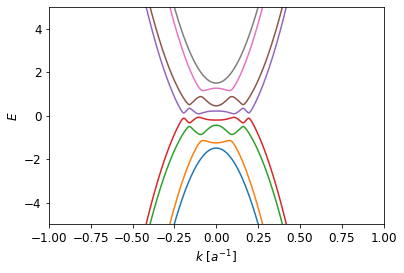

In [14]:
syst = make_system_mixed(L_A=3700., W=1400., a=6.083*10, m=0.023, alpha=350., mu=0.887, delta=0.182, B=0.8508921254871452, phi=0., eta=None)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
#plt.plot(momenta, dispersion(momenta, 1), ls=':')
#plt.plot(momenta, dispersion(momenta, 2), ls=':')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 1), marker='x')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 2), marker='x')
plt.xlabel(r'$k\ [a^{-1}]$')
plt.ylabel(r'$E$')
plt.xlim(-1, 1)
#plt.ylim(-2.5e4, 2.5e4)
plt.ylim(-5, 5)

print('Spectral gap:')
print(np.min(en[:,4]))
print(np.min(en[:,5]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/6.0583e-10
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length
local_minima = signal.argrelextrema(en[:,4], np.less)
print(local_minima)
print(en[local_minima, 4])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))

In [15]:
def phi_scan(phi_array=[0, 4.*np.pi], L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, delta=0.182, B=0., eta=None):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(phi_array[0], phi_array[1], 41):
        print(i)
        syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, delta=delta, B=B, phi=i, eta=eta)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [18]:
def phi_plot(energy_array, figure_title, delta=0.182, title=r'$L=1000, B=0.0182, \mu=0, \Delta=0.182$'):
    ex=[]
    ey=[]
    
    phi = np.linspace(0, 4*np.pi, 41)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)
    plt.title(title)
    #plt.savefig('./Real params/'+figure_title, dpi=300)

In [67]:
def e_i_plot(energy_array):
    ex=[]
    ey=[]
    
    phi = np.linspace(0, 4*np.pi, 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5, marker='*')
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)

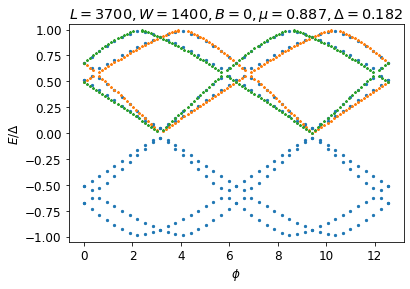

In [68]:
phi_plot(e_validation, 'sth', title=r'$L=3700, W=1400, B=0, \mu=0.887, \Delta=0.182$')
e_i_plot(e_1)
e_i_plot(e_2)
plt.ylim(-1.05, 1.05)
plt.savefig('./figs/8-orb validation', dpi=300, bbox_inches='tight')

In [74]:
e_B_phi_scan0 = []
psi_B_phi_scan0 = []
for i in np.linspace(0, 14.7*mu_B*2./2./const.e*1000./4., 26):
    e_array, psi_array = phi_scan(B=i)
    e_B_phi_scan0.append(e_array)
    psi_B_phi_scan0.append(psi_array)

0.0
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.12362582 -0.12362582 -0.09282837 -0.09282837  0.09282837  0.09282837
  0.12362582  0.12362582]
0.3141592653589793
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.13372573 -0.11460895 -0.09953074 -0.0844556   0.0844556   0.09953074
  0.11460895  0.13372573]
0.6283185307179586
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.14359232 -0.11424466 -0.09704628 -0.07565658  0.07565658  0.09704628
  0.11424466  0.14359232]
0.9424777960769379
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.1529075  -0.12

In [1]:
e_B_phi_scan0

NameError: name 'e_B_phi_scan0' is not defined

In [ ]:
e_B_phi_scan1 = []
psi_B_phi_scan1 = []
for i in np.linspace(14.7*mu_B*2./2./const.e*1000./4.+14.7*mu_B*2./2./const.e*1000./100., 14.7*mu_B*2./2./const.e*1000./2., 25):
    e_array, psi_array = phi_scan(B=i)
    e_B_phi_scan1.append(e_array)
    psi_B_phi_scan1.append(psi_array)

0.0
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.22123195262665776]
[-0.12564852 -0.12124718 -0.06549453  0.06549453  0.12124718  0.12564852]
0.3141592653589793
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.22123195262665776]
[-0.13242313 -0.11332877 -0.07089247 -0.0581154   0.0581154   0.07089247
  0.11332877  0.13242313]
0.6283185307179586
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.22123195262665776]
[-0.10310266 -0.07672823 -0.05147507  0.05147507  0.07672823  0.10310266]
0.9424777960769379
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.22123195262665776]
[-0.

In [ ]:
e_B_phi_scan2 = []
psi_B_phi_scan2 = []
for i in np.linspace(14.7*mu_B*2./2./const.e*1000./2.+14.7*mu_B*2./2./const.e*1000./100., 14.7*mu_B*2./2./const.e*1000./4.*3., 25):
    e_array, psi_array = phi_scan(B=i)
    e_B_phi_scan2.append(e_array)
    psi_B_phi_scan2.append(psi_array)

In [ ]:
e_B_phi_scan3 = []
psi_B_phi_scan3 = []
for i in np.linspace(14.7*mu_B*2./2./const.e*1000./4.*3.+14.7*mu_B*2./2./const.e*1000./100., 14.7*mu_B*2./2./const.e*1000., 25):
    e_array, psi_array = phi_scan(B=i)
    e_B_phi_scan3.append(e_array)
    psi_B_phi_scan3.append(psi_array)

In [43]:
len(e_1)

101

[[0.49729864469422586, 0.679486039046123], [0.5165005152703382, 0.6548941510936495], [0.5356103108667722, 0.6299345680462316], [0.5546220310552201, 0.6046349987219038], [], [0.5531159894032126, 0.5923252252957515], [0.5269419932027132, 0.6110025408976093], [0.5005193305327142, 0.6295533558087992], [0.4738670450476492, 0.6479691844239946], [0.447003004758973, 0.666240850558085], [0.4199440348461052, 0.6843583985857097], [0.3927060347442481, 0.7023109898555909], [0.3653040819316264, 0.7200867812566526], [0.33775252441883846, 0.7376727820126646], [0.3100650636390867, 0.7550546837187396], [0.28225482914479905, 0.7722166572368271], [0.2543344463309037, 0.7891411081742391], [0.2263160982109818, 0.8058083801365887], [0.19821158213551826, 0.8221963914398812], [0.17003236222748833, 0.8382801860957638], [0.14178961820676841, 0.8540313729969081], [0.11349429120442371, 0.8694174173231253], [0.08515712710026765, 0.8844007336662136], [0.05678871786698705, 0.8989375086492993], [0.028399541365196665, 

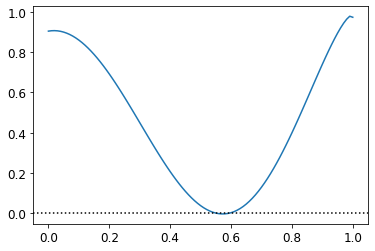

In [40]:
hbar = const.hbar
m_e = const.m_e
eV = const.e
mu_B = const.physical_constants['Bohr magneton'][0]
from scipy import optimize as op

def dispersion(k_x_over_a, j, a=6.0583e-10, m_star=0.023, W_nm=140, alpha_meVnm=35):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    #print(alpha)
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    k_x = k_x_over_a/a
    #print(eta/eV*1000.)
    #print(E_2_perp/eV*1000)
    #print((E_2_perp - E_1_perp)/eV*1000.)
    #print((E_1_perp-E_2_perp)/(2.*(-1.)**j*alpha)*6.0583e-10)
    return ((hbar*k_x)**2./(2.*m_star*m_e) + (E_1_perp+E_2_perp)/2. - np.sqrt((((E_1_perp-E_2_perp)/2.)+(-1.)**j*alpha*k_x)**2.+eta**2.))/eV*1000.

def k_F_given_mu(j, m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.887):
    def func(k_x):
        #print(k_x)
        #print(dispersion(k_x, j, a=a, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm)-mu_meV)
        return dispersion(k_x, j, a=a, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm)-mu_meV
    k_F = op.brentq(func, 0, 0.03)
    return k_F/a

def v_F_given_mu(m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.887):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    
    k_F1 = k_F_given_mu(1, m_star=m_star, W_nm=W_nm, alpha_meVnm=alpha_meVnm, a=a, mu_meV=mu_meV)
    k_F2 = k_F_given_mu(2, m_star, W_nm, alpha_meVnm, a, mu_meV)
    
    #print(k_F1-k_F2-2.*m_star*m_e*alpha/hbar**2.)
    
    v_1 = hbar*k_F1/(m_star*m_e) + (-1)**1*(alpha*((E_1_perp/2.)-(-1)**1*alpha*k_F1))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**1*alpha*k_F1)**2. + eta**2.))
    v_2 = hbar*k_F2/(m_star*m_e) + (-1)**2*(alpha*((E_1_perp/2.)-(-1)**2*alpha*k_F2))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**2*alpha*k_F2)**2. + eta**2.))
    
    #print(v_1-v_2)
    return np.array([v_1, v_2])

def lambda_i(j, delta=0.182, L=3700):
    delta_0 = delta/1000*eV
    L_0 = L*1e-10
    v_j = v_F_given_mu()[j-1]
    return delta_0*L_0/(hbar*v_j)

def transcendental_eq(e, phi, s):
    return np.sin(e*lambda_i(1, L=3695.563)-s*phi/2.-np.arccos(e))*np.sin(e*lambda_i(2, L=3695.563)+s*phi/2.-np.arccos(e))

def e_given_phi_s(phi, s):
    energies = np.linspace(0, 1, 101)
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(transcendental_eq(a, phi, s)) != np.sign(transcendental_eq(b, phi, s)):
                candidate = scipy.optimize.brentq(lambda e: transcendental_eq(e, phi, s), a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            print('error')
            continue
    return candidates

e_1 = []
e_2 = []
for phi in np.linspace(0, 4*np.pi, 101):
    e_1.append(e_given_phi_s(phi, -1))
    e_2.append(e_given_phi_s(phi, 1))
    
print(e_1)
print(e_2)

plt.plot(np.linspace(0, 1, 101), transcendental_eq(np.linspace(0, 1, 101), 4*np.pi*0.05, -1))
plt.axhline(0, color='k', ls=':')

In [38]:
e_2

[[0.49729864469422586, 0.679486039046123],
 [0.4780103439801508, 0.7036800020510037],
 [0.45864093706674924, 0.7274429143286599],
 [0.43919545781930186, 0.7507383084853211],
 [0.419678677531641, 0.7735258418246358],
 [0.40009512955859505, 0.7957606523150662],
 [0.38044913144880704, 0.817392574895484],
 [0.3607448049095626, 0.8383651791887685],
 [0.34098609387818235, 0.8586145762372271],
 [0.32117678093927265, 0.8780679228111338],
 [0.3013205022937873, 0.8966415242584183],
 [0.28142076145851586, 0.9142383962919239],
 [0.26148094185153326, 0.9307450850934181],
 [0.24150431839966222, 0.9460274511922706],
 [0.22149406828748763, 0.9599249740667923],
 [0.20145328095347279, 0.9722428924965072],
 [0.18138496742684523, 0.9827410876134186],
 [0.16129206908883284],
 [0.14117746593326913],
 [0.12104398439433259, 0.989826460535959, 0.9998328771837203],
 [0.10089440480406649, 0.9821289085706828],
 [0.08073146853069978, 0.9730023412538858],
 [0.06055788486335696, 0.9627031627569415],
 [0.040376337673

In [2]:
e_validation

NameError: name 'e_validation' is not defined

In [16]:
e_validation, psi_validation = phi_scan()

0.0
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.12362582 -0.12362582 -0.09282837 -0.09282837  0.09282837  0.09282837
  0.12362582  0.12362582]
0.3141592653589793
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.13372573 -0.11460895 -0.09953074 -0.0844556   0.0844556   0.09953074
  0.11460895  0.13372573]
0.6283185307179586
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.14359232 -0.11424466 -0.09704628 -0.07565658  0.07565658  0.09704628
  0.11424466  0.14359232]
0.9424777960769379
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
[-0.1529075  -0.12